## 16-10. 프로젝트: 카메라 앱에 당황한 표정 효과를 적용해보기

In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
from os.path import join
from glob import glob
from tqdm import tqdm
import numpy as np
import cv2
import math
import dlib
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
import glob

home_dir = os.getenv('HOME')+'/lfw'
list_image = sorted(glob.glob(home_dir+'/data/train/input/img/*.png'))
list_label = sorted(glob.glob(home_dir+'/data/train/label/mask/*.png'))
print (len(list_image), len(list_label))

# 32의 배수를 벗어나는 파일 경로들을 담은 list
list_image_out_of_range = list_image[len(list_image) - (len(list_image) % 32):]
list_label_out_of_range = list_label[len(list_label) - (len(list_label) % 32):]

# 해당 list가 존재한다면, 파일 삭제
if list_image_out_of_range:
    for path in list_image_out_of_range:
        os.remove(path)
if list_label_out_of_range:
    for path in list_label_out_of_range:
        os.remove(path)

IMAGE_SHAPE = (80, 120)
data_root = home_dir+'/data/train/input'
label_root = home_dir+'/data/train/label'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator = tf.keras.preprocessing.image.ImageDataGenerator()
image_data = image_generator.flow_from_directory(str(data_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)
label_data = label_generator.flow_from_directory(str(label_root), class_mode=None, target_size=IMAGE_SHAPE, batch_size=32)

24928 24928
Found 24928 images belonging to 1 classes.
Found 24928 images belonging to 1 classes.


#### 필요한 라이브러리를 불러오고, 미리 생성해 놓은 데이터도 읽어옵니다. 데이터를 살펴보니 오른된 눈과 왼쪽 눈 한쌍으로 된 데이터 셋이 24928개 확인됩니다.

In [3]:
def user_generation(train_generator, label_generator):
    h, w = train_generator.target_size
    for images, labels in zip(train_generator, label_generator):
        images /= 255.
        images = images[..., ::-1] # rgb to bgr

        list_point_labels = []
        for img, label in zip(images, labels):

            eye_ls = np.where(label==1) # leftside
            eye_rs = np.where(label==2) # rightside
            eye_center = np.where(label==3)

            lx, ly = [eye_ls[1].mean(), eye_ls[0].mean()]
            rx, ry = [eye_rs[1].mean(), eye_rs[0].mean()]
            cx, cy = [eye_center[1].mean(), eye_center[0].mean()]

            if len(eye_ls[0])==0 or len(eye_ls[1])==0:
                lx, ly = [0, 0]
            if len(eye_rs[0])==0 or len(eye_rs[1])==0:
                rx, ry = [w, h]
            if len(eye_center[0])==0 or len(eye_center[1])==0:
                cx, cy = [0, 0]

            np_point_label = np.array([lx/w,ly/h,rx/w,ry/h,cx/w,cy/h], dtype=np.float32)

            list_point_labels.append(np_point_label)
        np_point_labels = np.array(list_point_labels)
        yield (images, np_point_labels)

In [4]:
user_train_generator = user_generation(image_data, label_data)
for i in range(2):
    dd = next(user_train_generator)
    print (dd[0][0].shape, dd[1][0])

(80, 120, 3) [0.         0.         1.         1.         0.08257005 0.21897742]
(80, 120, 3) [0.         0.         1.         1.         0.57916665 0.40803364]


/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


#### 제너레이터 함수를 이용해 데이터를 리사이즈 하고 정규화 합니다.

### 1. 이론 시간에 다룬 모델을 참고하여 딥러닝 모델을 설계해 봅시다.

In [5]:
''' tf hub feature_extractor '''
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                            input_shape=(80,120,3))

image_batch = next(image_data)
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

num_classes = 6

feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid'),
])

model.summary()

(32, 2048)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 25,669,126
Trainable params: 2,104,326
Non-trainable params: 23,564,800
_________________________________________________________________


#### tf.keras.Sequential()을 이용해서 백본 네트워크와 fully connected layer를 쌓아서 모델을 만듭니다.

In [6]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='mse',
  metrics=['mae']
  )

#### 이 문제는 점을 맞는 위치로 추정하는 position regression 문제이기 때문에 loss와 metric을 각각 mse 와 mae 로 설정합니다.

In [7]:
def lr_step_decay(epoch):
    init_lr = 0.0005 #self.flag.initial_learning_rate
    lr_decay = 0.5 #self.flag.learning_rate_decay_factor
    epoch_per_decay = 2 #self.flag.epoch_per_decay
    lrate = init_lr * math.pow(lr_decay, math.floor((1+epoch)/epoch_per_decay))
    return lrate

In [8]:
steps_per_epoch = image_data.samples//image_data.batch_size
print (image_data.samples, image_data.batch_size, steps_per_epoch)
# 20160 32 630 -> 데이터를 batch_size 의 배수로 준비해 주세요.

learning_rate = LearningRateScheduler(lr_step_decay)

history = model.fit(user_train_generator, epochs=20,
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [learning_rate]
                    )

24928 32 779
Epoch 1/20


/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


779/779 [==============================] - 26s 30ms/step - loss: 0.0302 - mae: 0.0827
Epoch 2/20
779/779 [==============================] - 17s 22ms/step - loss: 0.0128 - mae: 0.0525
Epoch 3/20
779/779 [==============================] - 18s 23ms/step - loss: 0.0126 - mae: 0.0517
Epoch 4/20
779/779 [==============================] - 18s 23ms/step - loss: 0.0125 - mae: 0.0515
Epoch 5/20
779/779 [==============================] - 18s 23ms/step - loss: 0.0124 - mae: 0.0512
Epoch 6/20
779/779 [==============================] - 18s 24ms/step - loss: 0.0123 - mae: 0.0509
Epoch 7/20
779/779 [==============================] - 18s 24ms/step - loss: 0.0122 - mae: 0.0506
Epoch 8/20
779/779 [==============================] - 18s 23ms/step - loss: 0.0123 - mae: 0.0508
Epoch 9/20
779/779 [==============================] - 18s 23ms/step - loss: 0.0122 - mae: 0.0504
Epoch 10/20
779/779 [==============================] - 18s 23ms/step - loss: 0.0124 - mae: 0.0510
Epoch 11/20
779/779 [===================

#### 20 epoch만큼만 학습 시켜봅니다.

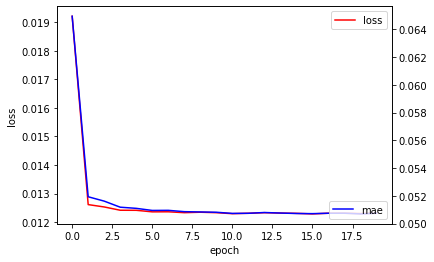

In [14]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'r', label='loss')
acc_ax.plot(history.history['mae'], 'b', label='mae')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')
acc_ax.legend(loc='lower right')
plt.savefig('result.png')
plt.show()

#### 근데 조금 이상하네요. 완만하게 loss가 감소하는게 아닌 초반에 확떨어지는 그래프를 그리네요. 결과가 어떻게 됬을지 궁금합니다.

In [16]:
IMAGE_SHAPE = (80, 120)

home_dir = os.getenv('HOME')+'/lfw'

val_data_root = home_dir + '/data/val/input'
val_label_root = home_dir + '/data/val/label'

image_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
label_generator_val = tf.keras.preprocessing.image.ImageDataGenerator()
image_data_val = image_generator.flow_from_directory(str(val_data_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)
label_data_val = label_generator.flow_from_directory(str(val_label_root), class_mode=None, target_size=IMAGE_SHAPE, shuffle=False)

Found 2782 images belonging to 1 classes.
Found 2782 images belonging to 1 classes.


In [17]:
user_val_generator = user_generation(image_data_val, label_data_val)
mse, mae = model.evaluate_generator(user_val_generator, image_data_val.n // 32)
print(mse, mae)

/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice.
  
/home/aiffel-dj50/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app


0.011951126158237457 0.049762532114982605


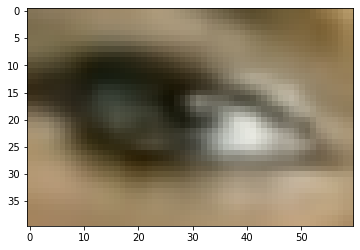

In [48]:
# img test
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(val_data_root+'/img/eye_001260_l.png')
img = cv2.resize(img, (60, 40))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#### 검증용 데이터중 하나를 불러왔습니다.

In [49]:
np_inputs = np.expand_dims(cv2.resize(img, (120, 80)), axis=0)
preds = model.predict(np_inputs/255., 1)

repred = preds.reshape((1, 3, 2))
repred[:,:,0] *= 120
repred[:,:,1] *= 80
print (repred)

[[[2.25063879e-03 2.32473249e-03]
  [1.19996925e+02 7.99996033e+01]
  [5.27369614e+01 2.67284470e+01]]]


[0. 0.]
[120.  80.]
[53. 27.]


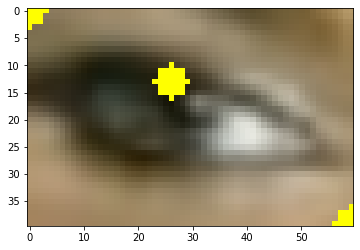

In [50]:
show = img.copy()
for pt in repred[0]:
    print (pt.round())
    show = cv2.circle(show, tuple((pt*0.5).astype(int)), 3, (0,255,255), -1)

plt.imshow(cv2.cvtColor(show, cv2.COLOR_BGR2RGB))
plt.show()

#### 에구머니나 이게 뭐죠? 뭔가 잘못된것 같습니다. 눈의 중앙과도 오차를 보이고 양쪽 눈의 위치는 더더욱 다릅니다^^;; 처음부터 다시해야 하나... ㅜㅜ

### 2. 눈동자 효과를 추가해 봅시다.

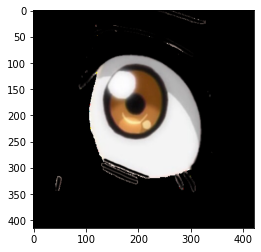

In [168]:
right = cv2.imread(val_data_root+'/test/test.png')
cropped_img = right[100: 1000, 300: 1000]
plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
plt.show()

#### 해커톤도 중요하니 일단은 그냥 진행해 봅니다. 놀란눈 한쪽 이미지를 준비합니다.

In [169]:
x = int(repred[0][2][0].round()*0.6)
y = int(repred[0][2][1].round()*0.6)
w = 30
h = 30
print ('(x,y) : (%d,%d)'%(x,y))
print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (31,16)
(w,h) : (30,30)


In [170]:
img_sticker = cv2.resize(cropped_img, (w,h))
print (img_sticker.shape)

(30, 30, 3)


In [171]:
refined_x = x - w // 2  # left
refined_y = y - h // 2      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (16,1)


In [172]:
img_sticker = img_sticker[refined_y:]
print (img_sticker.shape)

(29, 30, 3)


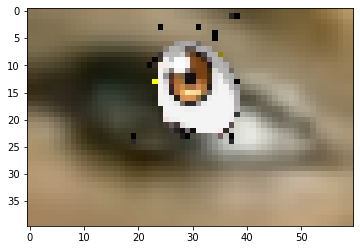

In [174]:
sticker_area = show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지 인식이 제대로 안되서 스티커도 역시 다른곳에 적용이 되네요. 몰라 앙 ㅜㅜ

## 총평

### 과제를 하는 내내 고양이 콧수염 붙이던 지난날이 떠오르더군요. 그땐 진짜 아무것도 모르고 했는데 지금이라고 뭐 크게 향상된건 아닌것 같습니다. ^^;; 너무 어렵네요 